In [1]:
!pip install missingno

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputer

In [10]:
# plotting defaults
sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (8,5)

# Load SPSS .sav (option A) or CSV (option B)
# Option A (if your file is .sav):
df = pd.read_excel(r"C:\Users\USER\Downloads\yrbs2023.xlsx")  # pandas can read .sav in recent versions

# Option B (if you have CSV):
# df = pd.read_csv("YRBSS_2023.csv")

df.shape, df.columns[:20]

((68, 107),
 Index(['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11',
        'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20'],
       dtype='object'))

In [11]:
# top rows
df.head()

# Data summary
df.info()     # types + missing info
df.describe(include="all").T   # summary for numeric & categorical


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Columns: 107 entries, Q1 to Q107
dtypes: float64(2), int64(104), object(1)
memory usage: 57.0+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Q1,68.0,NaN,NaN,NaN,5.602941,1.2234,1.0,5.0,6.0,7.0,7.0
Q2,68.0,NaN,NaN,NaN,1.691176,0.465443,1.0,1.0,2.0,2.0,2.0
Q3,68.0,NaN,NaN,NaN,2.985294,1.07193,1.0,2.0,3.0,4.0,5.0
Q4,68.0,NaN,NaN,NaN,1.882353,0.324585,1.0,2.0,2.0,2.0,2.0
Q5,68,11,E,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
Q103,68.0,NaN,NaN,NaN,2.632353,1.256677,1.0,2.0,2.0,3.25,5.0
Q104,68.0,NaN,NaN,NaN,3.647059,1.231001,1.0,3.0,4.0,4.25,5.0
Q105,68.0,NaN,NaN,NaN,1.573529,0.498241,1.0,1.0,2.0,2.0,2.0
Q106,68.0,NaN,NaN,NaN,1.485294,0.5035,1.0,1.0,1.0,2.0,2.0


In [16]:
# list the variables
selected_cols = [
    "Q1", "Q2", "Q3", "Q4", "Q5", "Q12", "Q13", "Q14", "Q15","Q18", "Q19", "Q20", "Q21", "Q22","Q23","Q24", "Q25","Q26", "Q27", "Q28", "Q29", "Q30", "Q31",
    "Q84", "Q85", "Q87", "Q67", "Q75"
]

# subset and check missing columns
present = [v for v in selected_cols if v in df.columns]
missing_cols = [v for v in selected_cols if v not in df.columns]
print("Present:", present)
print("Missing from dataset (check exact names):", missing_cols)

df = df[present].copy()
df.head()


Present: ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q12', 'Q13', 'Q14', 'Q15', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'Q31', 'Q84', 'Q85', 'Q87', 'Q67', 'Q75']
Missing from dataset (check exact names): []


,Q1,Q2,Q3,Q4,Q5,Q12,Q13,Q14,Q15,Q18,...,Q27,Q28,Q29,Q30,Q31,Q84,Q85,Q87,Q67,Q75
0,6,2,3,2,E,1,1,1,1,2,...,2,2,1,1,1,2,4,2,2,8
1,5,2,3,2,E,1,5,1,1,2,...,1,1,2,3,1,5,3,4,2,5
2,6,1,3,2,E,1,1,1,1,2,...,1,1,2,2,1,2,3,2,4,2
3,5,1,3,2,AB DE,5,1,1,1,2,...,1,2,1,1,1,4,2,7,1,1
4,6,1,4,2,E,1,1,1,1,1,...,1,1,1,1,1,5,4,2,4,3


In [17]:
df_vars_keep = df[selected_cols]
df_vars_keep.describe()

,Q1,Q2,Q3,Q4,Q12,Q13,Q14,Q15,Q18,Q19,...,Q27,Q28,Q29,Q30,Q31,Q84,Q85,Q87,Q67,Q75
count,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,...,68.000000,68.000000,68.000000,68.000000,68.0,68.000000,68.000000,68.000000,68.000000,68.000000
mean,5.602941,1.691176,2.985294,1.882353,1.558824,1.455882,1.617647,1.823529,1.514706,1.764706,...,1.514706,1.617647,1.602941,1.514706,1.0,3.529412,2.794118,2.852941,1.955882,3.470588
std,1.223400,0.465443,1.071930,0.324585,1.285770,1.226983,1.327431,1.900049,0.503500,0.427336,...,0.503500,0.489575,1.067005,0.782126,0.0,1.152163,1.409550,1.755713,1.071111,2.518413
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
25%,5.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,1.0,3.000000,2.000000,2.000000,1.000000,1.000000
50%,6.000000,2.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,...,2.000000,2.000000,1.000000,1.000000,1.0,4.000000,3.000000,2.000000,2.000000,3.000000
75%,7.000000,2.000000,4.000000,2.000000,1.000000,1.000000,1.000000,1.250000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,1.0,5.000000,4.000000,4.000000,2.250000,5.000000
max,7.000000,2.000000,5.000000,2.000000,5.000000,5.000000,5.000000,8.000000,2.000000,2.000000,...,2.000000,2.000000,5.000000,3.000000,1.0,5.000000,7.000000,7.000000,4.000000,8.000000


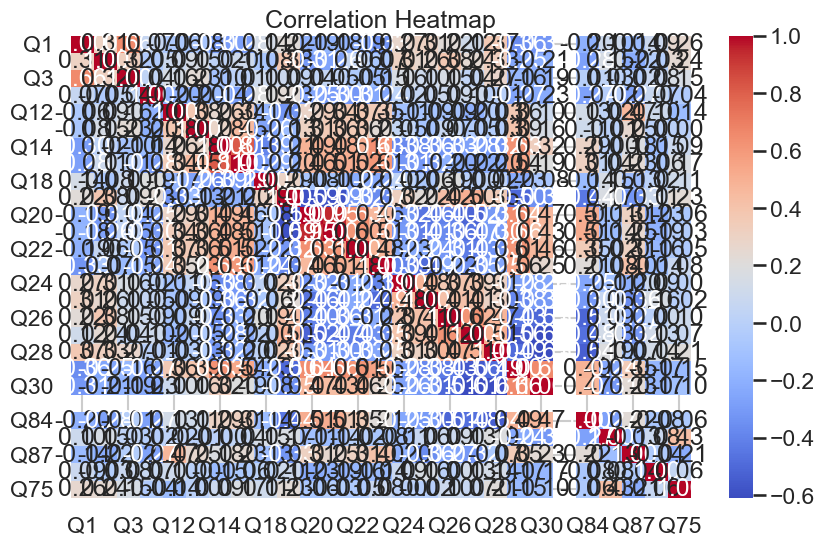

In [18]:
corr = df_vars_keep.corr(numeric_only=True)

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
for col in df_selected.columns:
    print(f"\n--- {col} ---")
    print(df_selected[col].value_counts())


In [6]:
# Recode target Q26 to 0/1: (some YRBSS use 1=Yes,2=No; adapt if different)
# convert to binary (1 = depressed/persistent sadness, 0 = not)
df['y'] = df['Q26'].replace({1:1, 2:0}).astype('Int64')  # 'Int64' supports NA




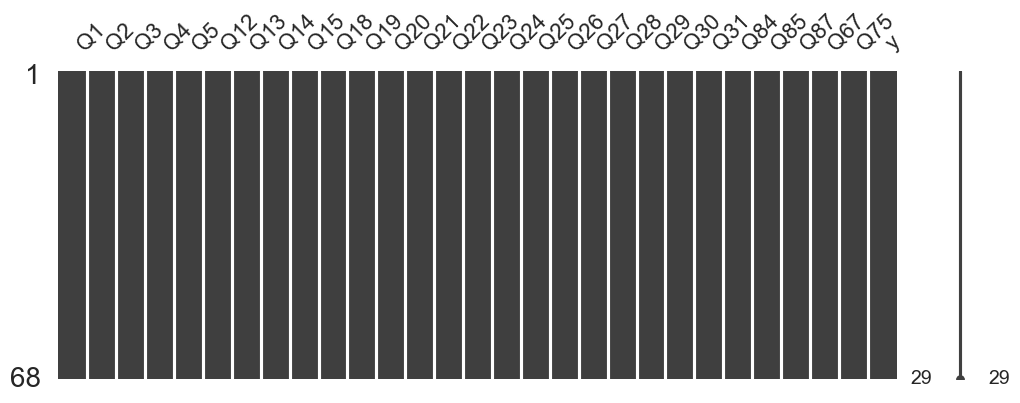

In [7]:
# percent missing per variable
missing_pct = df.isnull().mean().sort_values(ascending=False)
missing_pct = (missing_pct * 100).round(2)
missing_pct.head(20)

# Visualize missingness
msno.matrix(df, figsize=(12,4))
plt.show()


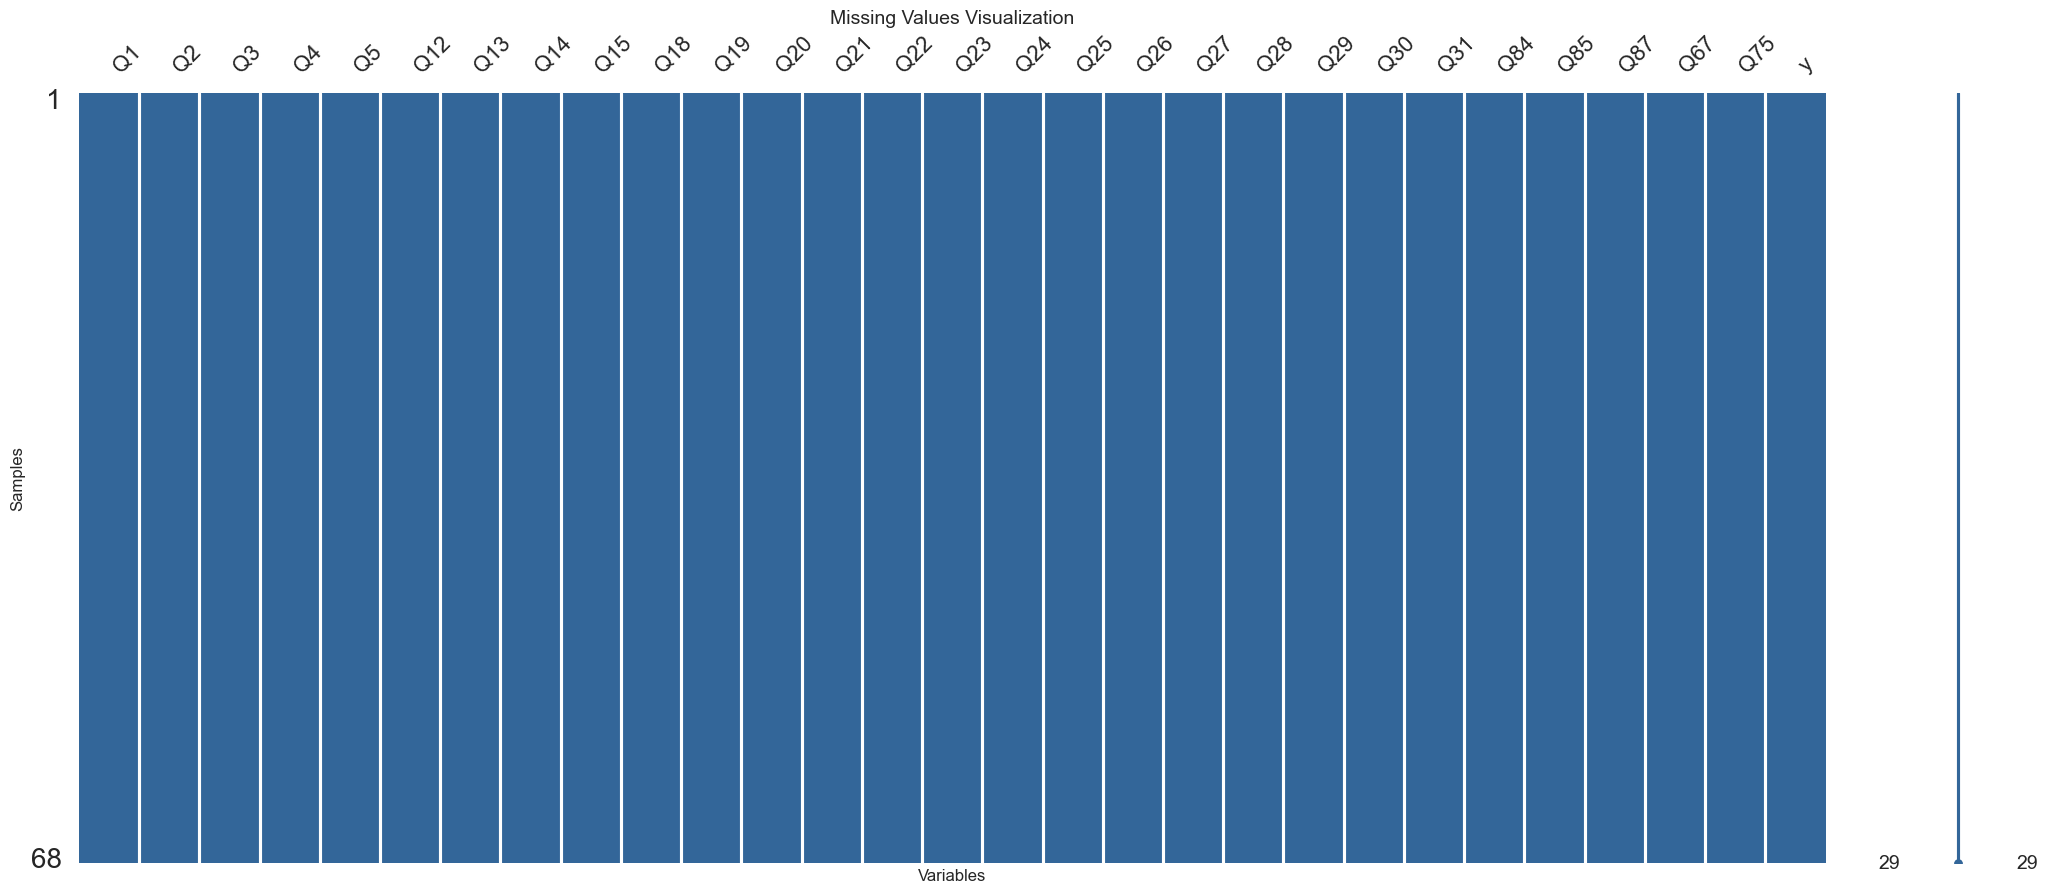

In [8]:
import missingno as msno
import matplotlib.pyplot as plt

# Colored missing value matrix
msno.matrix(df, color=(0.2, 0.4, 0.6))  # You can change this RGB color
plt.title("Missing Values Visualization", fontsize=14)
plt.xlabel("Variables", fontsize=12)
plt.ylabel("Samples", fontsize=12)
plt.show()
